<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/PyTorch/04_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom** Dataset
**source**: the original notebook created by [Daniel Bourke](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader as dl

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

import os
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Available device:", device)

Available device: cpu


In [4]:
# SEED
def set_seed(seed = 7):
  '''Sets the seed of the entire notebook so
  results are the same every time we run.'''
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

# 1. **Get** the data

In [5]:
import requests
import zipfile
from pathlib import Path

# setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} dirctory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)
  print("\n\nDone!")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


# 2. Data **Preparation**

In [6]:
### walk through the data ###
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and " +
          f"{len(filenames)} images in `{dirpath}`.")

# call it
walk_through_dir(image_path)

There are 2 directories and 0 images in `data/pizza_steak_sushi`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/train`.
There are 0 directories and 72 images in `data/pizza_steak_sushi/train/sushi`.
There are 0 directories and 78 images in `data/pizza_steak_sushi/train/pizza`.
There are 0 directories and 75 images in `data/pizza_steak_sushi/train/steak`.
There are 3 directories and 0 images in `data/pizza_steak_sushi/test`.
There are 0 directories and 31 images in `data/pizza_steak_sushi/test/sushi`.
There are 0 directories and 25 images in `data/pizza_steak_sushi/test/pizza`.
There are 0 directories and 19 images in `data/pizza_steak_sushi/test/steak`.


In [7]:
# setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### Visualize an image

Random image path: data/pizza_steak_sushi/train/steak/443210.jpg
Image class: steak
Image height: 512
Image width: 512


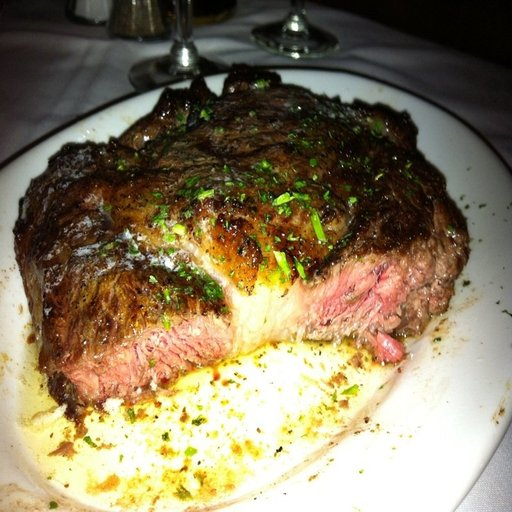

In [9]:
import random
from PIL import Image

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
# (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

# display the image
img

In [10]:
%%capture
# do the same with imshow()
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# 3. Transforming data

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

| Problem space | Pre-built Datasets and Functions |
| --- | --- |
| Vision | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| Audio | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| Text | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| Recommendation system | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

In [13]:
data_transform = transforms.Compose([
    # resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), # a kind of data augmentation
    transforms.ToTensor() # turn images into normalized tensors
])

In [14]:
def plot_transformed_images(image_paths, transform, n=3):
  """Plot a series of random images from image_paths.
  """
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0)
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

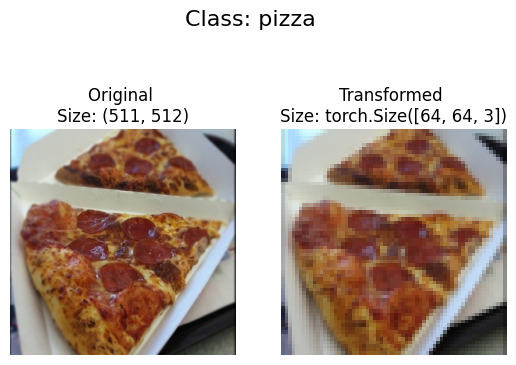

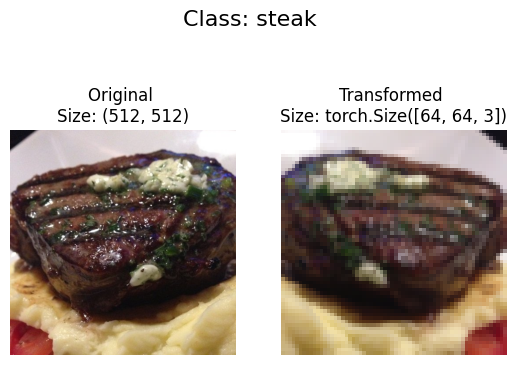

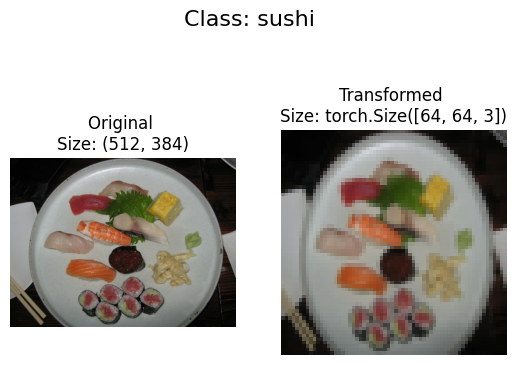

In [15]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

# 4. Loading Image Data
Time to turn our image data

## Option 1. Using `ImageFolder`

In [16]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.classes

['pizza', 'steak', 'sushi']

In [18]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
train_loader = dl(dataset=train_data, batch_size=1,
                  num_workers=1, shuffle=True)
test_loader = dl(dataset=test_data, batch_size=1,
                 num_workers=1, shuffle=False)

image, label = next(iter(train_loader))
print(f"Image shape: {image.detach().numpy().shape}")

Image shape: (1, 3, 64, 64)


## Option 2. With a custom `Dataset`

In [20]:
import os
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

In [21]:
# setup path for target directory
target_dir = train_dir

# get the class names from the target directory
class_names_found = sorted([
    entry.name for entry in list(os.scandir(image_path / "train"))
    ])
print(f"Class names found: {class_names_found}")

Class names found: ['pizza', 'steak', 'sushi']


**Explaination**:
1. Get the class names using os.scandir() to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dictionary of numerical labels, one for each class.

### Helper function to find classes

In [22]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Assumes target directory is in standard image classification format.
  """
  # 1. Get the class name by scanning the target directory
  classes = sorted(
      entry.name for entry in os.scandir(directory) if entry.is_dir()
      )
  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  # 3. create a directory of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [23]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Custom dataset class (inherits from `torch.utils.data.Dataset`)

In [40]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
    # get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transform
    self.transform = transform
    # create classes and classes to index attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # overwrite the __len__() method
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # overwrite the __getitem__() method
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.



In [42]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [43]:
# turn our images into dataset
custom_train = ImageFolderCustom(targ_dir=train_dir,
                                 transform=train_transforms)

custom_test = ImageFolderCustom(targ_dir=test_dir,
                                transform=test_transforms)

len(custom_train), len(custom_test)

(225, 75)

### Function to display random images

In [44]:
def display_images(dataset: torch.utils.data.dataset.Dataset,
                   classes: List[str] = None,
                   n: int = 10,
                   display_shape: bool = True):
  if n > 10:
    n = 10
    display_shape = False

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.detach().numpy().shape}"
    plt.title(title)

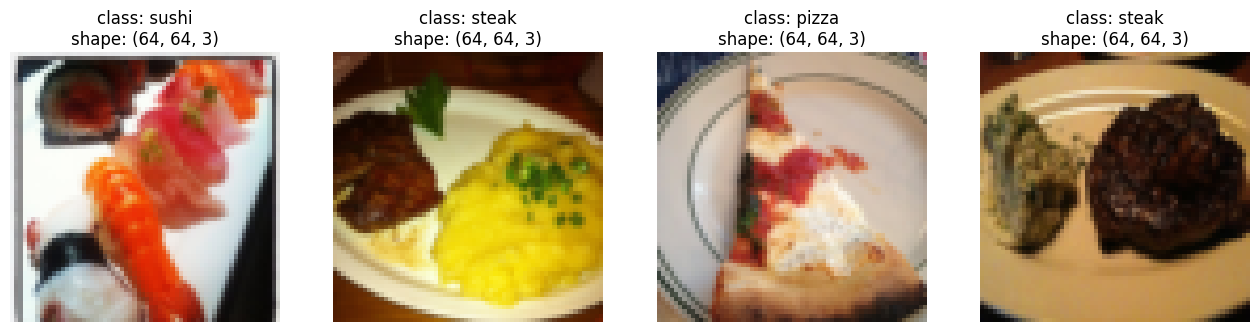

In [45]:
# display images created using ImageFolder
class_names = train_data.classes
display_images(train_data, n=4, classes=class_names)

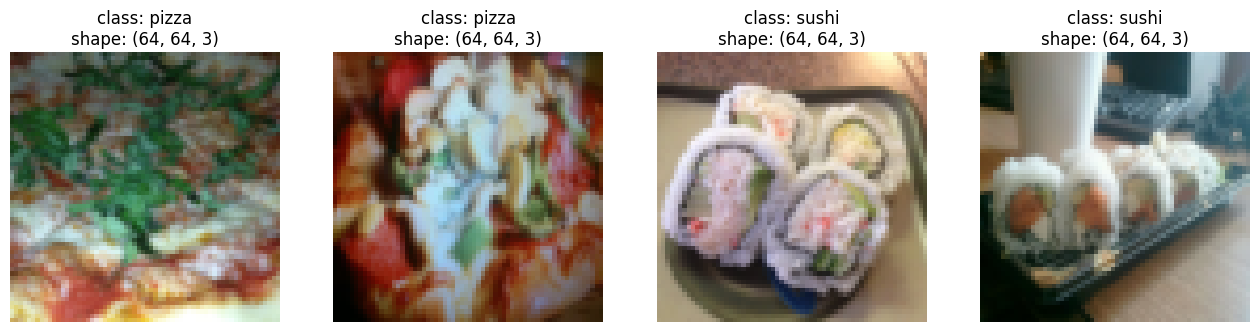

In [46]:
# display images created using custom dataset
class_names = custom_train.classes
display_images(custom_train, n=4, classes=class_names)

In [47]:
# Turn train and test custom Dataset's into DataLoader's
custom_train_loader = dl(dataset=custom_train, batch_size=1,
                  num_workers=0, shuffle=True)
custom_test_loader = dl(dataset=custom_test, batch_size=1,
                 num_workers=0, shuffle=False)

image, label = next(iter(custom_train_loader))
print(f"Image shape: {image.detach().numpy().shape}")

Image shape: (1, 3, 64, 64)
